In [1]:
import numpy as np
# import scipy.integrate as integrate
from math import *
import matplotlib.pyplot as plt
import scipy.stats as scs
import seaborn as sns
import plotly.graph_objects as go


In [4]:
def update_mu(mu_prime: float, lambd: float, a_0: float, b_0 : float, X: np.ndarray):
    mu = (lambd*mu_prime+np.sum(X))/(lambd+len(X))
    exeptation_tau = a_0/b_0
    tau = (lambd+len(X))*exeptation_tau
    return mu,tau

def update_tau(mu_prime: float, lambd: float , tau_0: float, mu_0: float, a: float, b : float, X: np.ndarray):
    a_1 = a + (N+1)/2
    b_1 = b + 1/2*(np.sum(np.power(X,2))+(np.power(mu_prime,2)*lambd)-2*mu_0*(np.sum(X)+lambd*mu_prime)+(len(X)+lambd)*(1/tau_0+mu_0**2))
    return a_1, b_1

def to_integrate(tau : float,mu : float, X: np.ndarray, mu_0 : float,tau_0 : float, a_0: float, b_0: float, mu_prime: float, lambd: float, a: float, b: float):
    q_mu = np.sqrt(tau_0/2*np.pi)*np.exp(-tau_0*np.power(mu-mu_0,2)/2)
    q_tau = np.power(b_0,a_0)/gamma(a_0)*np.power(tau,a_0-1)*np.exp(-b_0*tau)
    p_tau = np.power(b,a)/gamma(a)*np.power(tau,a-1)*np.exp(-b*tau)
    p_mu = np.sqrt(tau*lambd/2*np.pi)*np.exp(-tau*lambd*np.power(mu-mu_prime,2)/2)
    print(np.prod(np.sqrt(0.01/2*np.pi)*np.exp(-0.01*np.power(X-3,2)/2)))
    p_x = np.prod(np.sqrt(tau/2*np.pi)*np.exp(-tau*np.power(X-mu,2)/2))
    p = p_tau*p_mu*p_x
    print(p_tau,p_mu,p_x, q_mu, q_tau)
    return q_mu*q_tau * log(q_mu*q_tau/p)

def update_ELBO(X: np.ndarray, mu_0 : float,tau_0 : float, a_0: float, b_0: float, mu_prime: float, lambd: float, a: float, b: float) -> float:
    return integrate.dblquad(to_integrate,-100,100,0,100, args=(X,mu_0,tau_0,a_0,b_0,mu_prime,lambd,a,b))

def VI(X: np.ndarray,mu_prime : float,lambd : float,a : float,b : float, threshold: float):
    mu_0, tau_0, a_0, b_0 = 5, 5, 5, 5
    mu_1, tau_1, a_1, b_1 = 0, 1, 1, 1
    # ELBO = update_ELBO(X,mu_0,tau_0,a_0,b_0,mu_prime,lambd,a,b)
    # ELBO_previous=-np.inf
    # while((ELBO-ELBO_previous)>threshold):
    while(max(np.power(mu_0-mu_1,2),np.power(tau_0-tau_1,2),np.power(a_0-a_1,2),np.power(b_0-b_1,2))>threshold):
        mu_0, tau_0, a_0, b_0 = mu_1, tau_1, a_1, b_1
        mu_1,tau_1=update_mu(mu_prime,lambd,a_1,b_1,X)
        a_1,b_1 = update_tau(mu_prime,lambd,tau_1,mu_1,a,b,X)
        # ELBO_previous = ELBO
        # ELBO = update_ELBO(X,mu_0,tau_0,a_0,b_0,mu_prime,lambd,a,b)
    return mu_0, tau_0, a_0, b_0

def exactPosterior(X: np.ndarray,mu_prime : float,lambd : float,a : float,b : float):
    N=len(X)
    mu_star = (np.sum(X)+lambd*mu_prime)/(N+lambd)
    lambd_star = N+lambd
    a_star = N/2+a
    b_star = np.sum(np.power(X,2))/2+b+lambd*np.power(mu_prime,2)/2-lambd_star*np.power(mu_star,2)/2
    return mu_star,lambd_star,a_star,b_star

def print_comparison(val_VI: list, val_post: list, mu_prime : float,lambd : float,a : float,b : float,mu_val:float, tau_val:float, N: int, prior=False):
    x_mu = np.linspace(val_post[0]-2*np.sqrt(val_post[3]/(val_post[1]*val_post[2])),val_post[0]+2*np.sqrt(val_post[3]/(val_post[1]*val_post[2])),100)
    y_tau = np.linspace(val_post[2]/val_post[3]*(1-2/sqrt(N)),val_post[2]/val_post[3]*(1+2/sqrt(N)),100)
    if (prior):
        x_mu= np.linspace(min(val_post[0],mu_prime,mu_val)-2*np.sqrt(val_post[3]/(val_post[1]*val_post[2])),max(val_post[0],mu_prime,mu_val)+2*np.sqrt(val_post[3]/(val_post[1]*val_post[2])),100)
        y_tau = np.linspace(max(min(a/b/10,tau_val,val_post[2]/val_post[3]/5),0.05),max(a/b,val_post[2]/val_post[3]*2),100)
    XX, YY = np.meshgrid(x_mu,y_tau)

    q_tau = scs.gamma.pdf(x=y_tau,a=val_VI[2],scale=1/val_VI[3])
    q_mu  = scs.norm(val_VI[0],1/np.sqrt(val_VI[1])).pdf(x_mu)
    M = q_mu*np.transpose([q_tau])

    p_tau = scs.gamma.pdf(YY,a=val_post[2],scale=1/val_post[3])
    p_mu = scs.norm(val_post[0],np.sqrt(1/(val_post[1]*YY))).pdf(XX)
    M2 = p_tau*p_mu

    pp_tau = scs.gamma.pdf(YY,a=a,scale=1/b)
    pp_mu = scs.norm(mu_prime,1/(lambd*YY)).pdf(XX)
    M3 = pp_tau*pp_mu

    plt.figure(figsize=(10,8))
    plt.contour(XX,YY,M,colors='b',alpha=0.4)
    plt.contour(XX,YY,M2,colors='r',alpha=0.4)
    plt.scatter(val_VI[0],val_VI[2]/val_VI[3], marker="+",s=100, label="Variational Inference")
    plt.scatter(val_post[0],val_post[2]/val_post[3],s=50, label="Exact Posterior")
    if (prior):
        plt.contour(XX,YY,M3,colors='g',alpha=0.4)
        plt.scatter(mu_prime,a/b, label="Prior distribution")
        plt.scatter(mu_val,tau_val, label="Exact value")
    plt.legend(fontsize=10)
    plt.xlabel(r"Mean value $\mu$", fontsize=20)
    plt.ylabel(r"Precision value $\tau$", fontsize=20)
    plt.title(r"Probabilities for N = "+str(N)+" and $\lambda$="+str(round(lambd,2)))
    plt.xlim(x_mu[0],x_mu[-1])
    plt.ylim(y_tau[0],y_tau[-1])
    plt.show()

def print_comparison_2(val_VI: list, val_post: list, mu_prime : float,lambd : float,a : float,b : float,mu_val:float, tau_val:float, N: int, prior=False):
    x_mu = np.linspace(val_post[0]-2*np.sqrt(val_post[3]/(val_post[1]*val_post[2])),val_post[0]+2*np.sqrt(val_post[3]/(val_post[1]*val_post[2])),100)
    y_tau = np.linspace(val_post[2]/val_post[3]*(1-2/sqrt(N)),val_post[2]/val_post[3]*(1+2/sqrt(N)),100)
    if (prior):
        x_mu= np.linspace(min(val_post[0],mu_prime,mu_val)-2*np.sqrt(val_post[3]/(val_post[1]*val_post[2])),max(val_post[0],mu_prime,mu_val)+2*np.sqrt(val_post[3]/(val_post[1]*val_post[2])),100)
        y_tau = np.linspace(max(min(a/b/10,tau_val,val_post[2]/val_post[3]/5),0.05),max(a/b,val_post[2]/val_post[3]*2),100)
    XX, YY = np.meshgrid(x_mu,y_tau)

    q_tau = scs.gamma.pdf(x=y_tau,a=val_VI[2],scale=1/val_VI[3])
    q_mu  = scs.norm(val_VI[0],1/np.sqrt(val_VI[1])).pdf(x_mu)
    M = q_mu*np.transpose([q_tau])

    p_tau = scs.gamma.pdf(YY,a=val_post[2],scale=1/val_post[3])
    p_mu = scs.norm(val_post[0],np.sqrt(1/(val_post[1]*YY))).pdf(XX)
    M2 = p_tau*p_mu

    pp_tau = scs.gamma.pdf(YY,a=a,scale=1/b)
    pp_mu = scs.norm(mu_prime,1/(lambd*YY)).pdf(XX)
    M3 = pp_tau*pp_mu

    fig = go.Figure(data=[go.Surface(x=XX,y=YY,z=M),go.Surface(x=XX,y=YY,z=M2)])
    fig.show()
    plt.figure(figsize=(10,8))
    plt.contour(XX,YY,M,colors='b',alpha=0.4)
    plt.contour(XX,YY,M2,colors='r',alpha=0.4)
    plt.scatter(val_VI[0],val_VI[2]/val_VI[3], marker="+",s=100, label="Variational Inference")
    plt.scatter(val_post[0],val_post[2]/val_post[3],s=50, label="Exact Posterior")
    if (prior):
        plt.contour(XX,YY,M3,colors='g',alpha=0.4)
        plt.scatter(mu_prime,a/b, label="Prior distribution")
        plt.scatter(mu_val,tau_val, label="Exact value")
    plt.legend(fontsize=10)
    plt.xlabel(r"Mean value $\mu$", fontsize=20)
    plt.ylabel(r"Precision value $\tau$", fontsize=20)
    plt.title(r"Probabilities for N = "+str(N)+" and $\lambda$="+str(round(lambd,2)))
    plt.xlim(x_mu[0],x_mu[-1])
    plt.ylim(y_tau[0],y_tau[-1])
    plt.show()

In [173]:
np.random.normal(m,1/T,5)

array([7.60061725, 8.12093298, 8.47731228, 8.64940989, 9.24097122])

In [204]:
X

array([10.6368719 , -3.02633078])

In [238]:
T

0.1657642518481927

In [237]:
T

0.1657642518481927

In [361]:
m

4.926696942248464

In [236]:
np.random.normal(m,1/T,N)

array([10.13560605,  1.48992138])

In [205]:
v,p

((4.402635278843163, 0.3149638992338196, 4.5, 57.73440019403263),
 (4.402635278843163, 4, 4.0, 51.384466106776294))

In [6]:
np.meshgrid([1,2],[3,4])

[array([[1, 2],
        [1, 2]]),
 array([[3, 3],
        [4, 4]])]

C:\Users\VIANEY~1\AppData\Local\Temp/ipykernel_22732/370755180.py:98: RuntimeWarning:

invalid value encountered in sqrt



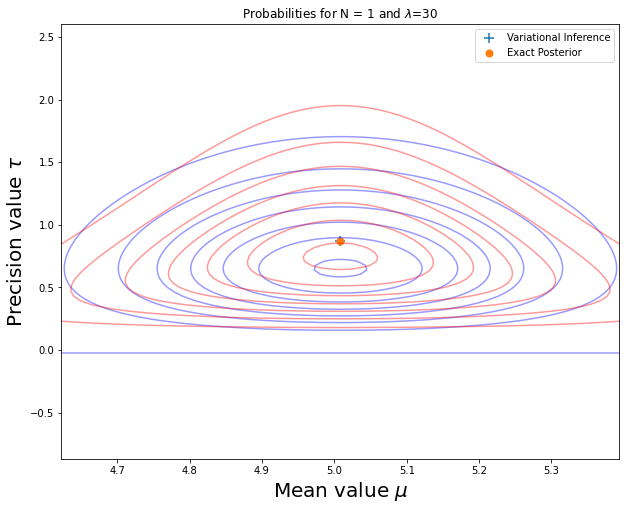

In [5]:
N=1
threshold = 0.1
mu_prime,lambd,a,b = 5, 30, 3, 4
T = np.random.gamma(a,1/b)
m = np.random.normal(mu_prime,1/np.sqrt(lambd*T))
X= np.random.normal(m,1/np.sqrt(T),N)
v = VI(X,mu_prime,lambd,a,b,threshold)
p = exactPosterior(X,mu_prime,lambd,a,b)
print_comparison_2(v,p,mu_prime,lambd,a,b, m,T,N)

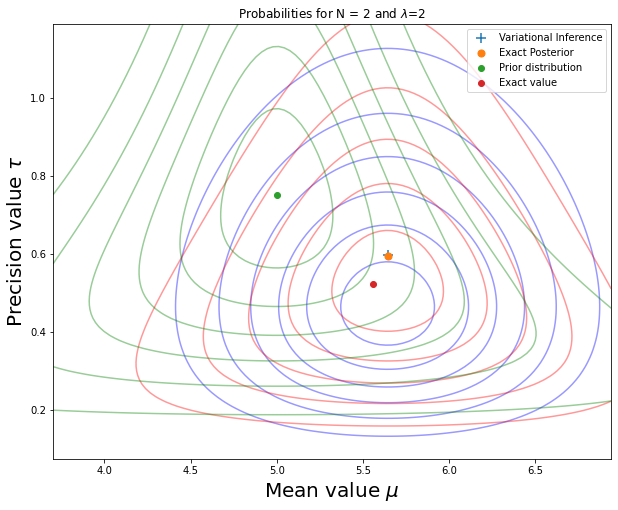

In [357]:
N=2
threshold = 0.1
mu_prime,lambd,a,b = 5, 2, 3, 4
T = np.random.gamma(a,1/b)
m = np.random.normal(mu_prime,1/(lambd*T))
X= np.random.normal(m,1/T,N)
v = VI(X,mu_prime,lambd,a,b,threshold)
p = exactPosterior(X,mu_prime,lambd,a,b)
print_comparison(v,p,mu_prime,lambd,a,b, m,T,N,prior=True)

In [ ]:
X

In [70]:
m,np.mean(X)

(0.5781092980847359, 0.6155495712381176)

In [317]:
print(p, p[2]/p[3]*)

(0.40819240658583705, 201, 101.0, 32.126860220437) 3.143786828435554


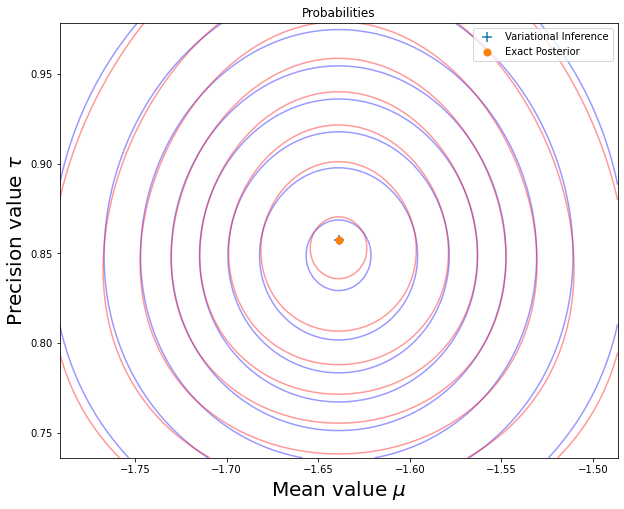

In [345]:
N=200
threshold = 0.05
mu_prime,lambd,a,b = 0, 1, 1, 1
T = np.random.gamma(a,b)
m = np.random.normal(mu_prime,np.sqrt(1/(lambd*T)))
X= np.random.normal(m,np.sqrt(1/T),N)
v = VI(X,mu_prime,lambd,a,b,threshold)
p = exactPosterior(X,mu_prime,lambd,a,b)
print_comparison(v,p,mu_prime,lambd,a,b,m,T,N)

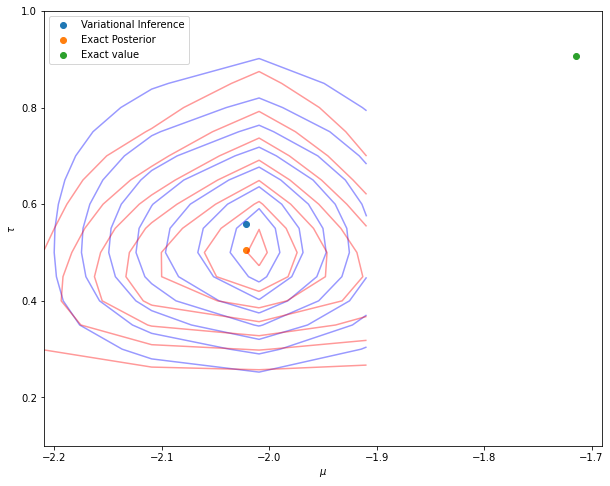

In [57]:
N=20
threshold = 0.1
mu_prime,lambd,a,b = 0, 1, 1, 1
T = np.random.gamma(a,b)
m = np.random.normal(mu_prime,1/(lambd*T))
X= np.random.normal(m,1/T,N)
v = VI(X,mu_prime,lambd,a,b,threshold)
p = exactPosterior(X,mu_prime,lambd,a,b)
print_comparison(v,p,mu_prime,lambd,a,b,m,T)

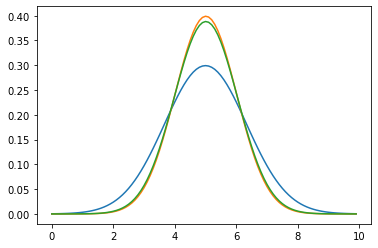

In [75]:
X = np.arange(0,10,0.1)
plt.plot(X,scs.norm(mu_prime,1/(a/b)).pdf(X))
plt.plot(X,scs.norm(v[0],1/(v[2]/v[3])).pdf(X))
plt.plot(X,scs.norm(p[0],1/(p[2]/p[3])).pdf(X))
# plt.plot(X,scs.norm(mu_prime,3).pdf(X))

In [82]:
X.mean(),m,T

(-1.9192468275080485, -1.9157205926135439, 1)

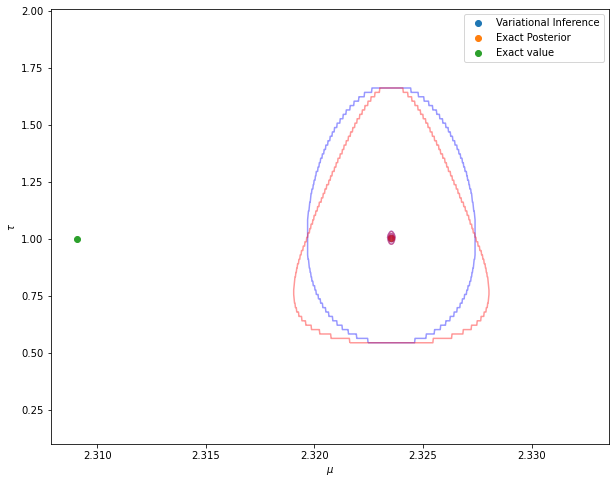

In [115]:
N=10000
threshold = 0.05
mu_prime,lambd,a,b = 0, 1, 1, 1
T = np.random.gamma(a,b)
m = np.random.normal(mu_prime,1/(lambd*T))
T=1
X= np.random.normal(m,1/T,N)
v = VI(X,mu_prime,lambd,a,b,threshold)
p = exactPosterior(X,mu_prime,lambd,a,b)

val_post = p
val_VI =v
prior=False
mu_val = m
# tau_val = T
gap = 0.01


x_mu = np.linspace(p[0]-gap,p[0]+gap,1000)
y_tau = np.linspace(max(a/b/10,0.05),p[2]/p[3]*2,100)
XX, YY = np.meshgrid(x_mu,y_tau)

q_tau = scs.gamma.pdf(x=y_tau,a=val_VI[2],scale=1/val_VI[3])
q_mu  = scs.norm(val_VI[0],1/val_VI[1]).pdf(x_mu)
M = q_mu*np.transpose([q_tau])

p_tau = scs.gamma.pdf(YY,a=p[2],scale=1/p[3])
p_mu = scs.norm(val_post[0],1/(val_post[1]*YY)).pdf(XX)
M2 = p_tau*p_mu

pp_tau = scs.gamma.pdf(YY,a=a,scale=1/b)
pp_mu = scs.norm(mu_prime,1/(lambd*YY)).pdf(XX)
M3 = pp_tau*pp_mu

plt.figure(figsize=(10,8))
plt.contour(XX,YY,M,colors='b',alpha=0.4, levels=4)
plt.contour(XX,YY,M2,colors='r',alpha=0.4, levels=4)
plt.scatter(val_VI[0],val_VI[2]/val_VI[3], label="Variational Inference")
plt.scatter(val_post[0],val_post[2]/val_post[3], label="Exact Posterior")
if (prior):
    plt.contour(XX,YY,M3,colors='g',alpha=0.4)
    plt.scatter(mu_prime,a/b, label="Prior distribution")
plt.scatter(mu_val,tau_val, label="Exact value")
plt.legend()
plt.xlabel(r"$\mu$")
plt.ylabel(r"$\tau$")
plt.show()

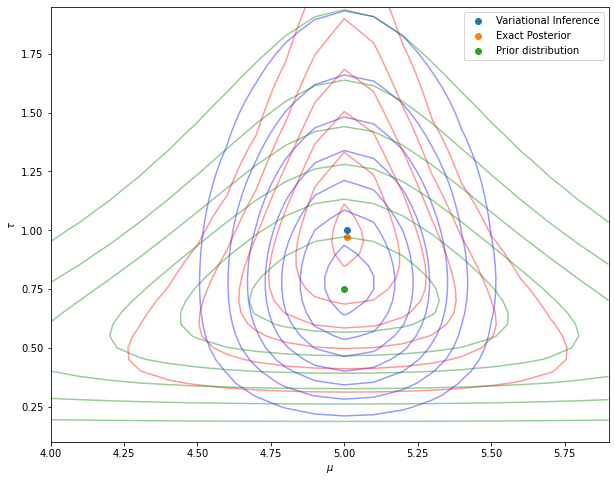

In [162]:
x_mu = np.arange(4,6,0.1)
y_tau = np.arange(0.1,2,0.05)
XX, YY = np.meshgrid(x_mu,y_tau)

q_tau = scs.gamma.pdf(x=y_tau,a=v[2],scale=1/v[3])
q_mu  = scs.norm(v[0],1/v[1]).pdf(x_mu)
M = q_mu*np.transpose([q_tau])

p_tau = scs.gamma.pdf(YY,a=p[2],scale=1/p[3])
p_mu = scs.norm(p[0],1/(p[1]*YY)).pdf(XX)
M2 = p_tau*p_mu

pp_tau = scs.gamma.pdf(YY,a=a,scale=1/b)
pp_mu = scs.norm(mu_prime,1/(lambd*YY)).pdf(XX)
M3 = pp_tau*pp_mu

plt.figure(figsize=(10,8))
plt.contour(XX,YY,M,colors='b',alpha=0.4)
plt.contour(XX,YY,M2,colors='r',alpha=0.4)
plt.contour(XX,YY,M3,colors='g',alpha=0.4)
plt.scatter(v[0],v[2]/v[3], label="Variational Inference")
plt.scatter(p[0],p[2]/p[3], label="Exact Posterior")
plt.scatter(mu_prime,a/b, label="Prior distribution")
plt.legend()
plt.xlabel(r"$\mu$")
plt.ylabel(r"$\tau$")
plt.show()